In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import itertools
from collections import defaultdict

import math
import nolds

#XGBoost now needs path to runtime compilers
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper

from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score


path = 'Z:\\Stroke MC10\\LabeledData\\'

In [2]:
current_palette = sns.color_palette()

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '--'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    
    return ax

In [3]:
def getFeatures(EMGSignal):
    
    EPS = .0001
    
    Feat = {}
    Feat['MeanAbsValue'] = np.mean(np.abs(EMGSignal))
    
    PosInds = EMGSignal>0
    Feat['ZeroCrossings'] = sum((PosInds[1:len(PosInds)] != PosInds[0:(len(PosInds)-1)]) & (np.abs(np.diff(EMGSignal))>EPS))
    
    DiffEMGSignal = np.diff(EMGSignal)
    PosInds = DiffEMGSignal>0
    Feat['SlopeZeroCrossings'] = sum((PosInds[1:len(PosInds)] != PosInds[0:(len(PosInds)-1)]) & 
                                     (np.abs(np.diff(DiffEMGSignal))>EPS))
    
    Feat['WaveformLength'] = np.mean(np.abs(EMGSignal[1:len(EMGSignal)-1]-EMGSignal[2:len(EMGSignal)]))
    
    Feat['WillisonAmplitude'] = sum(np.abs(EMGSignal[1:len(EMGSignal)-1]-EMGSignal[2:len(EMGSignal)])>EPS)
    
    Feat['RMS'] = math.sqrt(np.mean(np.square(EMGSignal)))
    
    Feat['Variance'] = np.var(EMGSignal)
    
    
    FFTPow = np.square(np.abs(np.fft.rfft(EMGSignal)))
    for i, key in enumerate(['FFT:0-20Hz', 'FFT:20-40Hz', 'FFT:40-60Hz', 'FFT:60-80Hz', 'FFT:80-100Hz', 'FFT:100-120Hz']):
        Feat[key] = np.sum(FFTPow[1+int(len(FFTPow)/6 * i):int(len(FFTPow)/6 * (i+1))])
    # TODO: Sample Entropy and FFT
    
    Feat['SampEn'] = nolds.sampen(EMGSignal)
    Feat['FFT:SampEn'] = nolds.sampen(FFTPow)
    
    return Feat

In [4]:
def getClips(EMGSignal, winsize, overlap):
    Clips = []
    Features = defaultdict(list)
    for indStart in range(0,int(len(EMGSignal)-winsize),int(winsize*(1-overlap))):
        Clip = np.asarray(EMGSignal[indStart:indStart+125])
        Feat = getFeatures(Clip)
        Clips.append(Clip)
        for key in Feat:
            Features[key].append(Feat[key])
        
    return Clips, Features

In [5]:
winsize = .5 * 250 # Test different values later (*250 to convert sec to samples)
overlap = .8 # 0-1; use value such that winsize*overlap is integer for now

RawDataClips = []
Features = defaultdict(list)
ClipLabels = []
SubjID = []
Location = []

for x in itertools.product(range(1,31),['Lab Day1','Lab Day2'],['Gastrocnemius', 'Hamstring'],['MAS', 'MVC', 'VCM']):
    if x[2]=='Hamstring':
        Act = 'KF'
    else:
        Act = 'PF'
    
    oldLen = len(RawDataClips)
    
    try:
        Data = pd.read_csv(path + 'CS' + str(x[0]).zfill(3) + '\\' + x[1] + '\\' + x[2] + '_' + x[3] + ' ' + Act + '_labeled.csv',
                          header = None)
        if x[2]=='Hamstring':
            Labind = 8
        else:
            Labind = 5
            
        EMGData = Data[4]
        Label = Data[Labind]
        
        for l in zip(['Spastic Activity', 'Non-Spastic Activity', 'Inactive'],['SA','HA','IA']):
            lab_old = l[0]
            lab_new = l[1]
            
            lab_inds = Label==lab_old
            lab_inds_diff = lab_inds[1:len(lab_inds)].values != lab_inds[0:len(lab_inds)-1].values
            
            # Get starts/ends of continuous labels
            cont_label_startend = [i+1 for i,x in enumerate(lab_inds_diff) if x]
            
            # Note: this assumes that the data stream begins and ends with unlabeled data
            # Even indices are starts, odds are ends
            for nLabel in range(0,len(cont_label_startend),2): 
                LabeledData = EMGData[cont_label_startend[nLabel]:cont_label_startend[nLabel+1]]
                
                newClips, newFeatures = getClips(LabeledData, winsize, overlap)
                
                RawDataClips += newClips
                for key in newFeatures:
                    Features[key] += newFeatures[key]
                SubjID += [x[0]] * len(newClips)
                ClipLabels += [lab_new]*len(newClips)
                Location += [x[2]]*len(newClips)
            
    except(FileNotFoundError):
        print(path + 'CS' + str(x[0]).zfill(3) + '\\' + x[1] + '\\' + x[2] + '_' + x[3] + ' ' + Act + '_labeled.csv')
        

Z:\Stroke MC10\LabeledData\CS001\Lab Day2\Gastrocnemius_MAS PF_labeled.csv
Z:\Stroke MC10\LabeledData\CS001\Lab Day2\Gastrocnemius_MVC PF_labeled.csv
Z:\Stroke MC10\LabeledData\CS001\Lab Day2\Gastrocnemius_VCM PF_labeled.csv
Z:\Stroke MC10\LabeledData\CS001\Lab Day2\Hamstring_MAS KF_labeled.csv
Z:\Stroke MC10\LabeledData\CS001\Lab Day2\Hamstring_MVC KF_labeled.csv
Z:\Stroke MC10\LabeledData\CS001\Lab Day2\Hamstring_VCM KF_labeled.csv
Z:\Stroke MC10\LabeledData\CS002\Lab Day1\Gastrocnemius_MVC PF_labeled.csv
Z:\Stroke MC10\LabeledData\CS002\Lab Day1\Hamstring_VCM KF_labeled.csv
Z:\Stroke MC10\LabeledData\CS003\Lab Day2\Hamstring_VCM KF_labeled.csv
Z:\Stroke MC10\LabeledData\CS004\Lab Day1\Gastrocnemius_MVC PF_labeled.csv
Z:\Stroke MC10\LabeledData\CS004\Lab Day1\Gastrocnemius_VCM PF_labeled.csv
Z:\Stroke MC10\LabeledData\CS005\Lab Day2\Gastrocnemius_VCM PF_labeled.csv
Z:\Stroke MC10\LabeledData\CS006\Lab Day1\Hamstring_MVC KF_labeled.csv
Z:\Stroke MC10\LabeledData\CS006\Lab Day2\Hamstri

In [6]:
FullData = pd.DataFrame(Features).assign(RawData=pd.Series(RawDataClips), SubjID=pd.Series(SubjID), Label=pd.Series(ClipLabels), Location=pd.Series(Location))

In [7]:
FullData

,FFT:0-20Hz,FFT:100-120Hz,FFT:20-40Hz,FFT:40-60Hz,FFT:60-80Hz,FFT:80-100Hz,FFT:SampEn,MeanAbsValue,RMS,SampEn,SlopeZeroCrossings,Variance,WaveformLength,WillisonAmplitude,ZeroCrossings,Label,Location,RawData,SubjID
0,1.225662e-05,4.522854e-07,2.080007e-05,1.905953e-05,4.014563e-06,3.042505e-06,0.556572,0.000043,0.000092,0.277610,15,8.436106e-09,0.000043,16,9,SA,Gastrocnemius,"[-1.25376354234e-05, 0.000256419017388, 0.0004...",1
1,5.124028e-06,6.583027e-07,3.939429e-06,8.017607e-06,5.152335e-06,2.913537e-06,0.942043,0.000033,0.000060,0.463364,18,3.540996e-09,0.000038,14,9,SA,Gastrocnemius,"[8.08939505107e-07, -2.33183855797e-06, -4.602...",1
2,5.312090e-06,5.734201e-07,3.906457e-06,7.764215e-06,6.000345e-06,3.090440e-06,0.985817,0.000035,0.000060,0.436390,19,3.625765e-09,0.000039,15,10,SA,Gastrocnemius,"[-2.2293540973e-05, -2.42760420198e-05, 7.0794...",1
3,6.055964e-06,9.395089e-07,3.285854e-06,6.913268e-06,6.285378e-06,3.981738e-06,1.600704,0.000035,0.000063,0.386144,20,4.010015e-09,0.000042,17,10,SA,Gastrocnemius,"[1.93068892395e-05, 1.69887587254e-05, 6.47013...",1
4,5.827616e-06,1.039353e-06,4.252874e-06,6.997786e-06,1.188937e-05,3.757468e-06,1.317301,0.000039,0.000069,0.321747,22,4.724903e-09,0.000044,18,13,SA,Gastrocnemius,"[-0.000173487217802, 0.000171276140095, 0.0002...",1
5,6.261542e-06,8.362098e-07,2.119474e-06,6.362588e-06,1.052013e-05,2.142752e-06,0.639304,0.000035,0.000061,0.308831,22,3.758845e-09,0.000040,18,12,SA,Gastrocnemius,"[-1.63350170387e-05, -1.41610687417e-05, -1.22...",1
6,5.533980e-06,6.667094e-07,1.906726e-06,5.236596e-06,8.559667e-06,2.166945e-06,0.747214,0.000033,0.000058,0.304867,21,3.337509e-09,0.000038,17,11,SA,Gastrocnemius,"[-1.56471798788e-05, -7.82617694864e-06, -3.36...",1
7,5.375414e-06,6.613987e-07,2.067963e-06,5.204622e-06,8.579560e-06,2.288197e-06,0.678963,0.000033,0.000058,0.309790,21,3.335843e-09,0.000039,17,11,SA,Gastrocnemius,"[2.20124916002e-05, 3.09398729699e-05, -5.9918...",1
8,5.001544e-06,1.356672e-06,2.179394e-06,6.259976e-06,8.564737e-06,2.566378e-06,1.168571,0.000034,0.000059,0.322334,20,3.506683e-09,0.000040,17,11,SA,Gastrocnemius,"[-1.30542601869e-05, -8.25301806449e-06, 1.219...",1
9,5.587417e-06,1.269544e-06,2.988758e-06,5.107652e-06,5.699606e-06,2.719225e-06,1.315677,0.000031,0.000057,0.275398,17,3.218736e-09,0.000034,13,8,SA,Gastrocnemius,"[0.000185240720243, 0.000247237986477, -3.9048...",1


In [8]:
[sum(FullData.SubjID[FullData.Location=='Hamstring']==s) for s in FullData.SubjID[FullData.Location=='Hamstring'].unique()]

[89, 436, 224, 446, 569, 103, 108, 752, 473, 238, 92, 659, 176, 159, 20]

In [9]:
[sum(FullData.SubjID[FullData.Location=='Gastrocnemius']==s) for s in FullData.SubjID[FullData.Location=='Gastrocnemius'].unique()]

[127,
 162,
 355,
 197,
 388,
 418,
 182,
 434,
 284,
 298,
 32,
 386,
 10,
 17,
 86,
 275,
 282,
 137,
 145,
 310,
 63]

In [10]:
#fit base-level and meta-level classifier 
def fit_stacking(X_train,y_train,groups): 
    
    base_classifiers = [];     meta_classifier = []
    subj = LeaveOneGroupOut()

    Xtrain_meta = np.zeros((len(y_train),len(models))) #stores the meta-level classifier features (posterior of each base-level classifier)
    ytrain_meta = np.array([]) #stores the labels to train meta-classifier
    i = 0 #counter for current classifier trained

    #CV to train base level clf and obtain train features for meta-level
    for clf,name in zip(models,model_name):

        print(name)
        yscoreCV = np.array([])  #stores the posterior prob of each base-level clf

        #CV to obtain posteriors from each clf (meta-features)
        for train, test in subj.split(X_train, y_train, groups):
            clf.fit(X_train[train,:],y_train[train])
            yscore = clf.predict_proba(X_train[test,:]) 
            yscore = yscore[:,1]
            yscoreCV = np.append(yscoreCV,yscore) #concatenate scores for each fold
            if i == 0:
                #store labels to train metaclassifier ()
                ytrain_meta = np.append(ytrain_meta,y_train[test])

        Xtrain_meta[:,i] = yscoreCV #store the posterior of current clf
        i +=1

        #Train base level classifiers on all training data    
        clf.fit(X_train,y_train)
        base_classifiers.append(clf)
        
    print('base-level classifiers trained')
        
    #add extra meta-features 
    metastd = np.std(Xtrain_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtrain_meta = np.concatenate((Xtrain_meta,metastd.T),axis=1)
    
    #train meta-level classifier on posteriors (this needs another CV to optimize parameters)
    meta_scaler = preprocessing.StandardScaler().fit(Xtrain_meta)
    Xtrain_meta = meta_scaler.transform(Xtrain_meta)
    print('training meta-classifier')
#     metaclf = LogisticRegression()
    metaclf = GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3)
    metaclf.fit(np.concatenate((Xtrain_meta,X_train),axis=1),ytrain_meta)
    ypred_meta = metaclf.predict_proba(np.concatenate((Xtrain_meta,X_train),axis=1))
#     ind = np.where(np.array(ypred_meta) != np.array(ytrain_meta))
#     print Xtrain_meta[:10,:]
#     plt.figure(figsize=(12,8))
#     sns.heatmap(Xtrain_meta[ind,:])

    meta_classifier.append(metaclf)

    return base_classifiers, meta_classifier[0], meta_scaler

In [11]:
def predict_stacking(X_test,y_test,base_classifiers,meta_classifier,meta_scaler):
    
    Xtest_meta = np.zeros((len(y_test),len(base_classifiers))) #stores the base clf predictions for current subj
    auc_base = np.empty( (len(models),1) ) #store auc for each base classifier
    i = 0 #clf index

    #1. base-classifiers predictions
    for clf,name in zip(base_classifiers,model_name):
        Xtest_meta[:,i] = clf.predict_proba(X_test)[:,1]
        auc_base[i] = roc_auc_score(y_test, Xtest_meta[:,i])
        i+=1
    print('best base-clf %s, auc = %.3f, worst base-clf %s, minauc = %.3f' % (model_name[np.argmax(auc_base)],
                                                                       np.max(auc_base),
                                                                       model_name[np.argmin(auc_base)],
                                                                       np.min(auc_base)))

    #add extra meta features
    metastd = np.std(Xtest_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtest_meta = np.concatenate((Xtest_meta,metastd.T),axis=1)

    #2. meta-level clf predictions (final prediction)
    Xtest_meta = meta_scaler.transform(Xtest_meta)
    yscore_meta = meta_classifier.predict_proba(np.concatenate((Xtest_meta,X_test),axis=1))[:,1]
    ypred_meta = meta_classifier.predict(np.concatenate((Xtest_meta,X_test),axis=1))
    auc_meta = roc_auc_score(y_test, yscore_meta)
    print('auc meta = %.3f\n' % (auc_meta))

    return ypred_meta, yscore_meta

In [12]:
def LOSOCV(X,y,data,groups,models,stacking=1):

    TAUC_all=[]; Tfpr_all=[]; Ttpr_all=[]; TSens_all=[]; TSpec_all=[] #store results for each subject
    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    for train_index, test_index in subj.split(X, y, groups):
        
        Dtr = data.iloc[train_index]
        Dte = data.iloc[test_index] #the left out subject to test the classifier on
        
        #ML classifier
        if stacking == 0:
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            models.fit(Xtr,ytr)
            ypred = models.predict(Xte)
            yscore = models.predict_proba(Xte)
            yscore = yscore[:,1]
            
        else: #stacking - need a second round of CV on the train data set
            groups2 = Dtr.SubjID.as_matrix()
            Xtr = Dtr.iloc[:,0:14].as_matrix(); ytr = Dtr.Label
            Xte = Dte.iloc[:,0:14].as_matrix(); yte = Dte.Label
            Xtr = np.asarray(Xtr); ytr = np.asarray(ytr) #it took me 4hours to figure this line was needed!
            Xte = np.asarray(Xte); yte = np.asarray(yte) #it took me 4hours to figure this line was needed!
#             Xtr = scaler.transform(Xtr)
#             Xte = scaler.transform(Xte)
            base_classifiers, meta_classifier, meta_scaler = fit_stacking(Xtr,ytr,groups2) #train base and meta clf
            ypred, yscore = predict_stacking(Xte,yte,base_classifiers,meta_classifier,meta_scaler)

        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec
        #randomforest
        ind = np.argmax(tpr-fpr)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)

        print('AUC = %.4f, Sens = %.4f, Spec = %.4f\n'%(roc_auc,Sens,Spec)) #random forest
        

    #summary results
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))

    results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all}
    return results

In [13]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          LogisticRegression(),
          SVC(kernel='linear',C=1,cache_size=800,probability=True,random_state=3),
         ]
model_name = ['Random Forest','Gradient Boosting','SVM']

AUC = 0.4002, Sens = 0.9524, Spec = 0.1300

AUC = 0.4058, Sens = 0.8585, Spec = 0.2000

AUC = 0.3698, Sens = 0.0000, Spec = 1.0000

AUC = 0.6878, Sens = 0.4400, Spec = 0.9100

AUC = 0.7274, Sens = 0.8000, Spec = 0.5800

AUC = 0.6269, Sens = 0.6923, Spec = 0.6200

AUC = 0.7320, Sens = 0.7727, Spec = 0.6800

AUC = 0.8127, Sens = 0.7344, Spec = 0.7300

AUC = 0.8232, Sens = 0.9355, Spec = 0.6000

AUC = 0.8507, Sens = 0.9500, Spec = 0.7900

AUC = 0.9371, Sens = 1.0000, Spec = 0.8500

AUC = 0.8021, Sens = 1.0000, Spec = 0.5800

AUC = 0.4199, Sens = 0.9744, Spec = 0.1000

mean AUC = 0.661 (+/- 0.380)
mean Sens = 0.778 (+/- 0.543)
mean Spec = 0.598 (+/- 0.557)


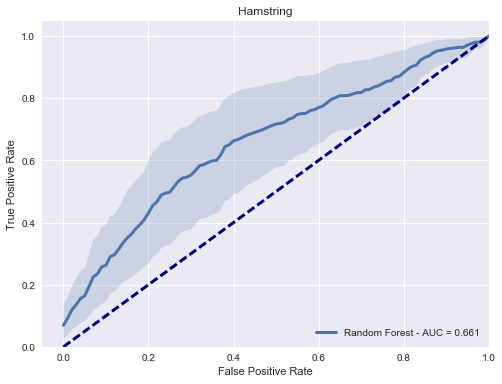

In [20]:
l = 'Hamstring'

Labels = FullData.Label

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]

Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        

results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),models[1],0)

plt.figure(figsize=(8,6))
AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname='Random Forest')
AX.set_title(l)

In [57]:
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)

In [58]:
FiltData

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Label,Location,SubjID
0,2.254397,-0.513330,1.799336,0.225191,-0.286650,-0.463088,-2.028599,1.640326,1.549046,-1.643914,-0.534542,0.871589,0.251514,-0.033614,True,Hamstring,1
1,1.510232,-0.397709,1.858363,0.153711,-0.344658,-0.464766,-1.936532,1.400863,1.390853,-1.672869,-0.534542,0.732233,0.113368,-0.033614,True,Hamstring,1
2,0.582325,-0.350644,1.201758,0.162859,-0.251559,-0.344043,-1.404613,0.966351,0.914982,-0.884510,-0.164863,0.384361,0.181815,-0.256042,True,Hamstring,1
3,0.350532,-0.267122,1.005469,-0.049457,-0.158315,-0.306987,-0.331587,0.721680,0.708784,-0.634226,-0.016991,0.249520,0.212062,-0.367256,True,Hamstring,1
4,0.527026,-0.232900,1.051238,-0.004187,-0.139314,-0.166611,0.054463,0.902456,0.862024,-0.964941,0.204816,0.348976,0.349531,-0.256042,True,Hamstring,1
5,0.770211,-0.140203,0.765167,0.010667,-0.096763,-0.032003,0.961688,0.955092,0.888809,-0.419454,0.130881,0.366776,0.344762,-0.256042,True,Hamstring,1
6,0.713675,-0.256739,0.746455,-0.020338,-0.169971,-0.152057,-0.362655,0.884524,0.769849,-0.490494,0.130881,0.288346,0.335904,-0.256042,True,Hamstring,1
7,0.578840,-0.366442,0.811116,-0.152166,-0.251469,-0.361703,-0.738544,0.784134,0.635011,-0.580427,-0.312734,0.203662,0.087422,-0.367256,True,Hamstring,1
8,0.710026,-0.503207,0.801505,-0.104591,-0.268093,-0.399737,-1.381261,0.764770,0.632291,-0.230758,-0.386670,0.201437,-0.007055,-0.367256,True,Hamstring,1
9,1.024573,-0.540033,0.677032,-0.155904,-0.355332,-0.525371,-1.214982,0.783990,0.626089,-0.230758,-0.534542,0.198289,-0.156276,-0.478470,True,Hamstring,1


In [54]:
pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})

,Label,Location,SubjID
0,True,Hamstring,1
1,True,Hamstring,1
2,True,Hamstring,1
3,True,Hamstring,1
4,True,Hamstring,1
5,True,Hamstring,1
6,True,Hamstring,1
7,True,Hamstring,1
8,True,Hamstring,1
9,True,Hamstring,1


In [55]:
pd.DataFrame(Features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2.254397,-0.513330,1.799336,0.225191,-0.286650,-0.463088,-2.028599,1.640326,1.549046,-1.643914,-0.534542,0.871589,0.251514,-0.033614
1,1.510232,-0.397709,1.858363,0.153711,-0.344658,-0.464766,-1.936532,1.400863,1.390853,-1.672869,-0.534542,0.732233,0.113368,-0.033614
2,0.582325,-0.350644,1.201758,0.162859,-0.251559,-0.344043,-1.404613,0.966351,0.914982,-0.884510,-0.164863,0.384361,0.181815,-0.256042
3,0.350532,-0.267122,1.005469,-0.049457,-0.158315,-0.306987,-0.331587,0.721680,0.708784,-0.634226,-0.016991,0.249520,0.212062,-0.367256
4,0.527026,-0.232900,1.051238,-0.004187,-0.139314,-0.166611,0.054463,0.902456,0.862024,-0.964941,0.204816,0.348976,0.349531,-0.256042
5,0.770211,-0.140203,0.765167,0.010667,-0.096763,-0.032003,0.961688,0.955092,0.888809,-0.419454,0.130881,0.366776,0.344762,-0.256042
6,0.713675,-0.256739,0.746455,-0.020338,-0.169971,-0.152057,-0.362655,0.884524,0.769849,-0.490494,0.130881,0.288346,0.335904,-0.256042
7,0.578840,-0.366442,0.811116,-0.152166,-0.251469,-0.361703,-0.738544,0.784134,0.635011,-0.580427,-0.312734,0.203662,0.087422,-0.367256
8,0.710026,-0.503207,0.801505,-0.104591,-0.268093,-0.399737,-1.381261,0.764770,0.632291,-0.230758,-0.386670,0.201437,-0.007055,-0.367256
9,1.024573,-0.540033,0.677032,-0.155904,-0.355332,-0.525371,-1.214982,0.783990,0.626089,-0.230758,-0.534542,0.198289,-0.156276,-0.478470
